In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


## ADAN 7431 Sentiment Analysis on Movie Reviews
### Alice Tang 

For our assignment, we were tasked with conducting sentiment analysis on the Rotten Tomatoes movie review dataset. We will label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Challenges for this assignment will include sentence negation, sarcasm, terseness, and language ambiguity. Let's see how we perform on this task, shall we? :)

This code was done in a Kaggle environment run with GPU P100. Running time was around 1 hour.

We first start with loading and unzipping the data.

In [2]:
import pandas as pd
import zipfile

# Unzip train and test files
with zipfile.ZipFile("/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip", "r") as z_train:
    z_train.extractall("/kaggle/working/")
    
with zipfile.ZipFile("/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip", "r") as z_test:
    z_test.extractall("/kaggle/working/")

# Load train and test data into DataFrames
train = pd.read_csv("/kaggle/working/train.tsv", sep='\t')
test = pd.read_csv("/kaggle/working/test.tsv", sep='\t')

Before creating our model, we must dive into some EDA so we understand the data we're working with. We'll begin to do that here.

Let's check the train and test data shape first.

In [3]:
train.shape, test.shape

((156060, 4), (66292, 3))

The train dataset has 156060 samples with 4 features, while the test dataset has 66292 samples with 3 features. Let's examine the first few entries of the train and the test data.

In [4]:
print("First few entries of the train data:")
train.head()

First few entries of the train data:


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
print("First few entries of the test data:")
test.head()

First few entries of the test data:


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


Now we'll do a quick overview of the train data. This will tell us the columns, non-null counts, and the data types.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


We'll check for missing values.

In [7]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

Great! We have no missing values. Now, we're going to map the numerical sentiment labels to their description, such as "negative", "somewhat negative", "neutral", "somewhat positive", "positive". By doing this, it's a lot easier to understand what the sentiment is associated with each review versus just looking at a number.

In [8]:
train['sentiment_class'] = train['Sentiment'].map({0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive',4:'positive'})
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


Okay, now that we've done a little bit of data exploration, we'll clean the data a bit before we engage in further EDA. We'll start with removing punctuation, as it does not contribute significantly to sentiment analysis and removing it will simplify the text data.

In [9]:
import string
def remove_punctuation(text):
    return "".join([t for t in text if t not in string.punctuation])

In [10]:
train['Phrase']=train['Phrase'].apply(lambda x:remove_punctuation(x))
train.head() # Checking if it worked.

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


Next, we will filter out words that have less than 2 characters. This helps with getting removing short or less informative words from the text data, which also does not contribute much to sentiment analysis.

In [11]:
def words_with_more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>3])

In [12]:
train['Phrase']=train['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage that what...,1,somewhat negative
1,2,1,series escapades demonstrating adage that what...,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


Now we will remove any stop words, since they do not carry significant meaning or carry weight in the overall context of the text. 

In [13]:
import nltk
from nltk.corpus import stopwords

stop_words=stopwords.words('english')
train['Phrase']=train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


After this, we'll check sentiment categories. 

In [14]:
train.groupby('Sentiment')['Sentiment'].count()

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

Let's visualize the target variables now to gain a better understanding.

<Axes: title={'center': 'Target class'}, xlabel='sentiment_class'>

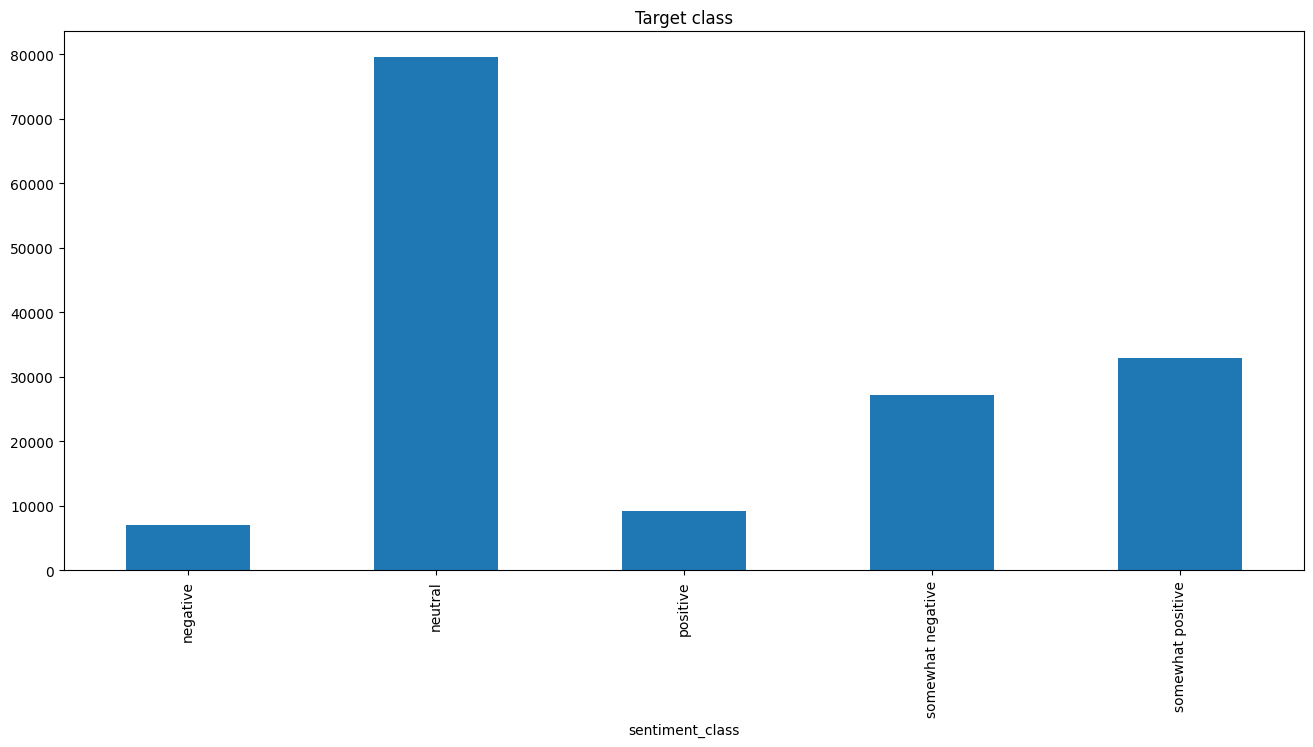

In [15]:
train.groupby('sentiment_class')['sentiment_class'].count().plot(kind='bar',title='Target class',figsize=(16,7),grid=False)

We can see that the overwhelming majority of reviews are neutral. Let's examine the percentages now.

<Axes: title={'center': '% Target class'}, ylabel='sentiment_class'>

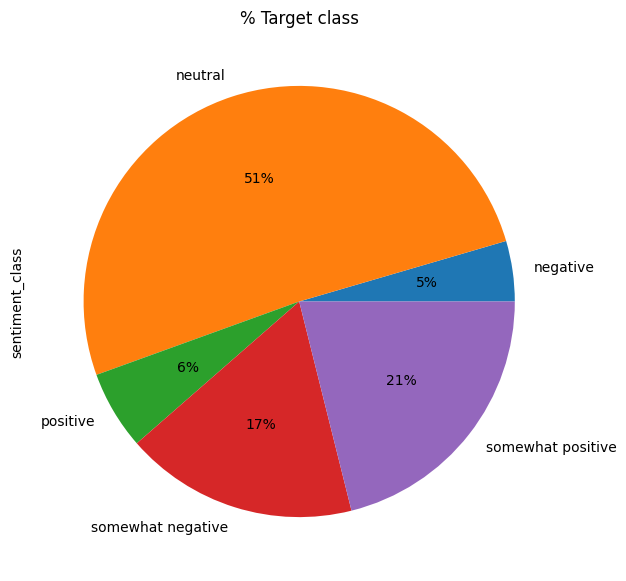

In [16]:
((train.groupby('sentiment_class')['sentiment_class'].count()/train.shape[0])*100).plot(kind='pie',figsize=(7,7),title='% Target class', autopct='%1.0f%%')

51% of reviews were neutral, 21% were somewhat positive, 17% were somewhat negative, 6% were positive, and 5% were negative. So for the data, we're mainly working with neutral reviews. I would expect due to some class imbalances, the model may train better on the neutral reviews and not be able to discern postive or negative reviews as well.

We can also take a look at the sentiment in relation to review word lengths.

In [17]:
# Create a new column called "PhraseLength".
train['PhraseLength']=train['Phrase'].apply(lambda x: len(x))

# Sort the values.
train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
54876,54877,2734,Filmmakers Dana JanklowiczMann Amir Mann area ...,3,somewhat positive,207
62992,62993,3189,addition sporting worst titles recent cinemati...,0,negative,200
26148,26149,1199,movie biggest shocks come seeing former nymphe...,1,somewhat negative,199
62500,62501,3162,While transgressive trappings especially frank...,1,somewhat negative,197
72577,72578,3708,Stephen Earnhart documentary decomposition hea...,1,somewhat negative,196


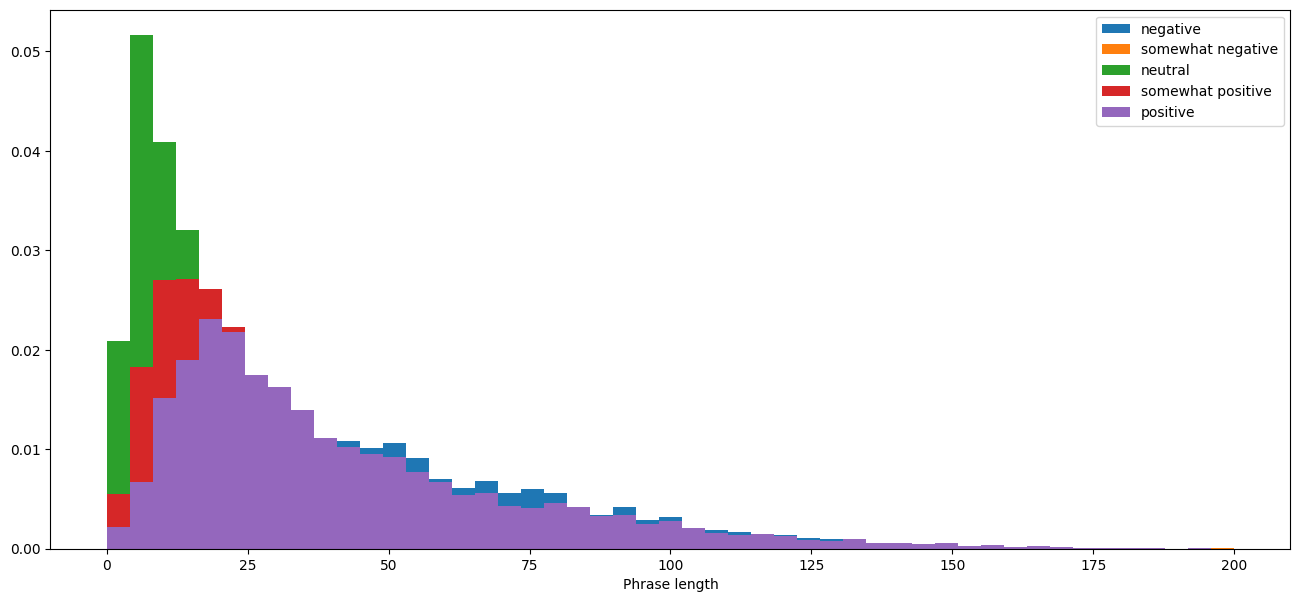

In [18]:
# With this in mind, we're ready to plot.
import matplotlib.pyplot as plt 

plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['sentiment_class']=='negative']['PhraseLength'],bins=bins,density=True,label='negative')
plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'],bins=bins,density=True,label='somewhat negative')
plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'],bins=bins,density=True,label='neutral')
plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(train[train['sentiment_class']=='positive']['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

From the plot above, we can see that positive reviews typically tend to have longer phrase length, followed by negative reviews. This is quite expected, because typically if someone feels passionate about a certain matter, they would be more willing to expend more effort into writing a longer review. 

We can also find the most common word used in reviews with a WordCloud.

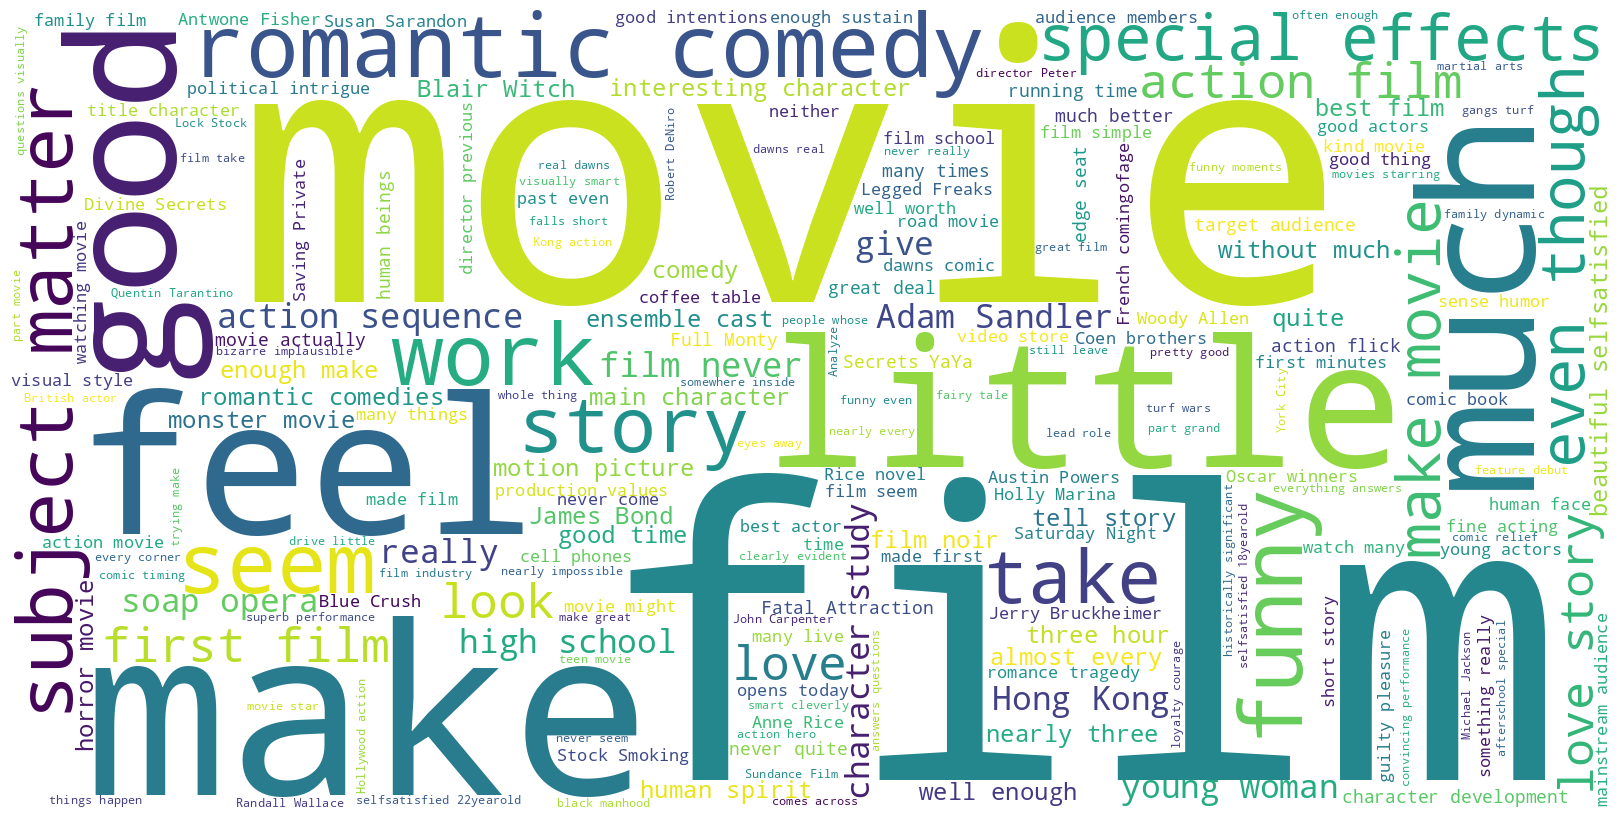

In [19]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

word_cloud_common_words=[]  
for index, row in train.iterrows(): 
    word_cloud_common_words.append((row['Phrase'])) 
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(''.join(word_cloud_common_words)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Words such as "film", "movie", "feel", "make", and "little" appear the most in movie reviews. We can delve further into this by examining the frequency of the most common words in movie reviews. 

In [20]:
# Here, we iterate over each row of the train dataset, and extract the text data from the phrase column. 

import nltk
from nltk.tokenize import word_tokenize

text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words) # Tokenize the concatenated text into individual words. 

In [21]:
from nltk import FreqDist

# Create the frequency distribution of individual words in the list.
freq_words=FreqDist(total_words)

In [22]:
# Find the 10 most common words and the count of each one. 
print(freq_words.most_common(10))

[('film', 3259), ('movie', 2892), ('like', 1968), ('story', 1204), ('much', 1085), ('good', 1069), ('even', 1041), ('characters', 994), ('little', 976), ('make', 838)]


<Axes: >

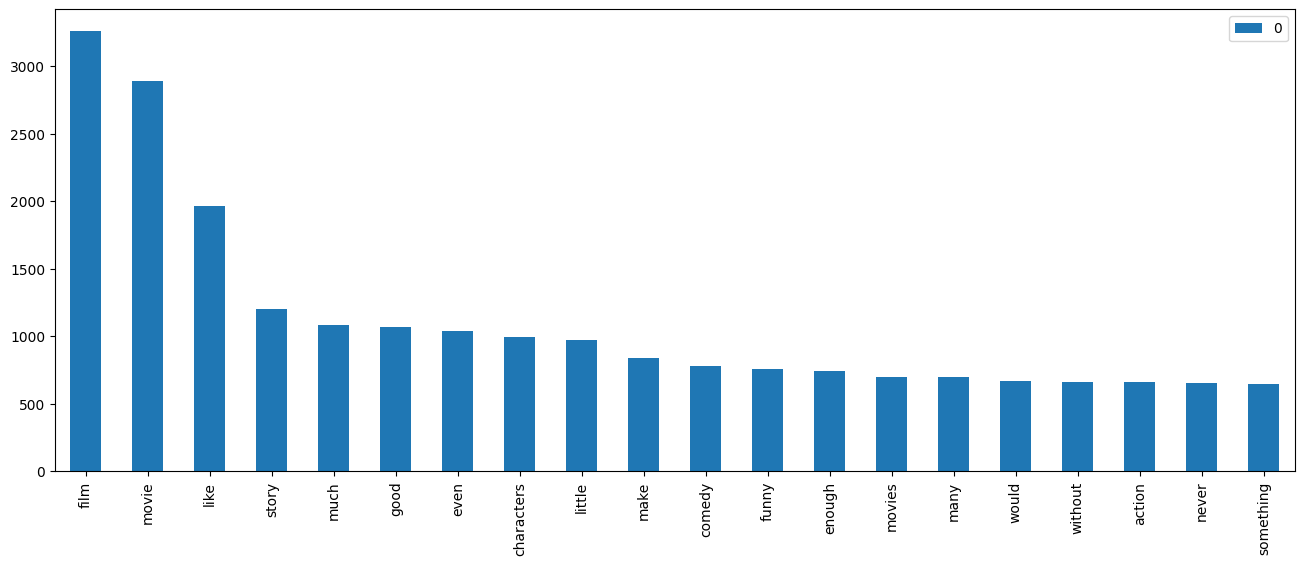

In [23]:
# Visualizing with a bar chart. 
pd.DataFrame(freq_words,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=False)

"Film" appears over 3000 times, "Movie" just under 3000, and "Like" barely under 2000. 

Out of curiosity, we can also look at the most common words in reviews with negative and positive sentiment. 

Perhaps, this could aim to tell us a little bit more about what reviewers value or talk about when determining if their sentiment towards that movie is negative or positive.

In [24]:
# Create a "negative" text list. 
neg_text_list=[]  
for index, row in train[train['Sentiment']==0].iterrows(): 
    neg_text_list.append((row['Phrase'])) 
neg_text_list

neg_total_words=' '.join(neg_text_list) # Concatenate text
neg_total_words=word_tokenize(neg_total_words) # Tokenizing

# Finding the frequency distribution of negative words. 
neg_freq_words=FreqDist(neg_total_words)

<Axes: >

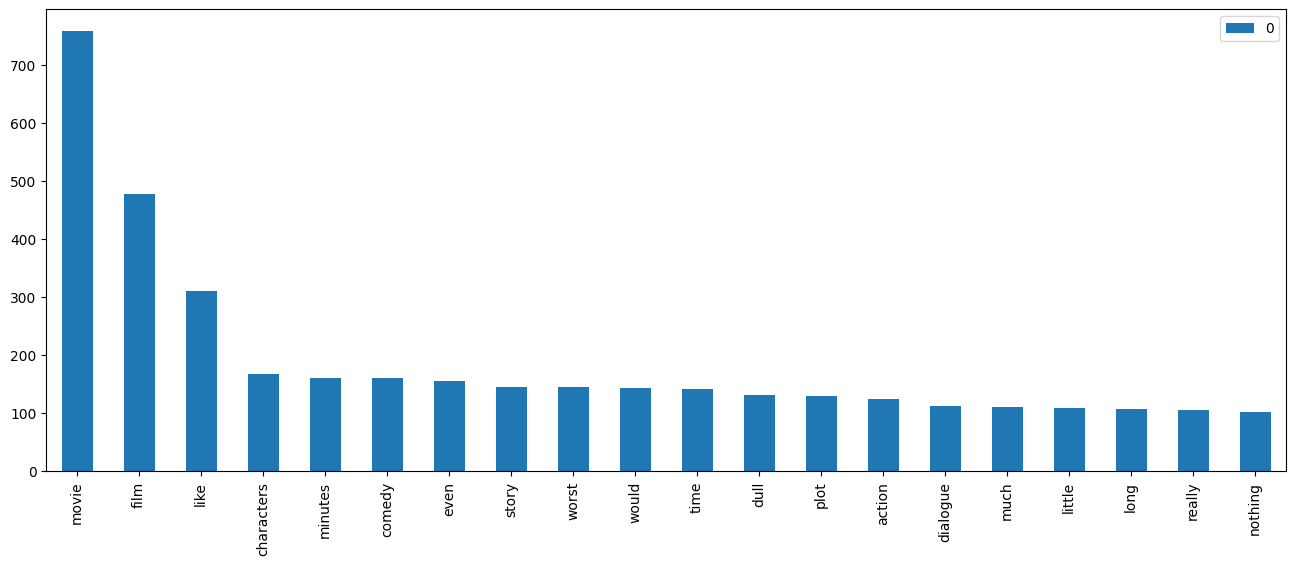

In [25]:
# Visualizing the most common words used in negative reviews. 
pd.DataFrame(neg_freq_words,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=False)

The top 3 words are the same, but words such as "character", "comedy", "minutes", "story" show up quite regularly in these reviews. Let's examine the positive sentiment words now. 

In [26]:
# Creating a list to store text data from phrases associated with positive sentiments.
pos_text_list=[]  
for index, row in train[train['Sentiment']==4].iterrows(): 
    pos_text_list.append((row['Phrase'])) 
pos_text_list

pos_total_words=' '.join(pos_text_list) # Concatenate text
pos_total_words=word_tokenize(pos_total_words) # Tokenize words.

pos_freq_words=FreqDist(pos_total_words) # Creating frequency distribution of words extracted from positive sentiment phrases in the reviews.

<Axes: >

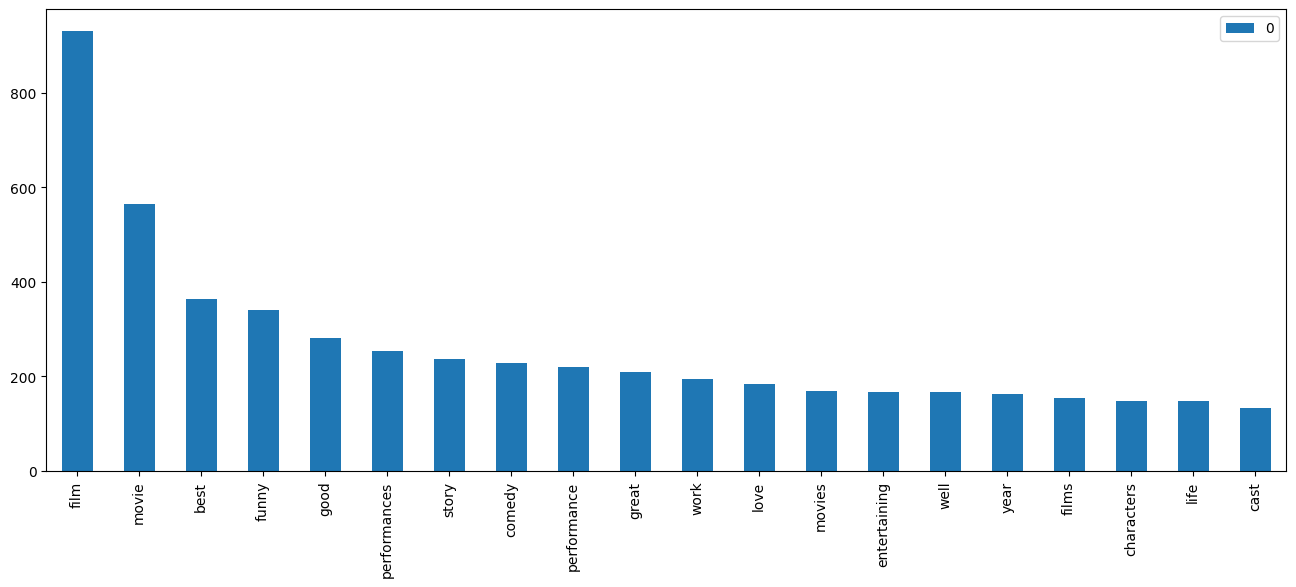

In [27]:
# Visualizing the most commonly used words in positive reviews.
pd.DataFrame(pos_freq_words,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=False)

Words that are commonly used in positive sentiment reviews include "best", "funny", "good", "performances", "story", and "comedy". 

From our EDA, we have a more comprehensive understanding of the data. Now, we are able to use a model to complete sentiment analysis on these reviews and see how we do.

### Model Training and Evaluation

In terms of models, I'm interested in using a DeBERTa-v3 base model. 

I actually used this model previously with named entity recognition which performed quite well. I have high hopes for decent results because DeBERTa v3 is a transformer model. It is a pre-trained model, trained on vast amounts of text data (which will be quite important especially in this task where labeled data is limited) with a deep understanding of contextual language. Due to DeBERTa-v3's attention mechanism, it weighs the importance of different words in a sentence. In turn, this can allow the model to focus on important parts of the text when making predictiions about sentiment. Additionally, transformer models are known for being data-efficient, meaning that they are able to achieve strong performance even when training with limited labeled data. 

It sounds quite promising, doesn't it? I'm very curious in seeing how it'll perform with sentiment analysis, so let's try it, shall we? :) 

In [28]:
# Import needed packages.
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score
from transformers import AutoModelForSequenceClassification

2024-04-07 21:43:12.225010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 21:43:12.225106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 21:43:12.354819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
# Splitting into training and validation sets with 20% saved for validation. 
train_df, valid_df = train_test_split(train, test_size=0.2, stratify=train['Sentiment']) # Stratify will ensure distribution of target variable maintains balanced classes.

# Loading tokenizer and DeBERTa model. 
model_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5) # Labels = 5 because we have 5 classes.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Defining the data collator which handles padding of sequences that ensures uniform length within each batch. 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Defining the training arguments including learning rate, batch size, and epochs. 
training_args = TrainingArguments(
    warmup_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    report_to='tensorboard',
    logging_strategy="steps",
    evaluation_strategy='epoch',
    save_strategy="epoch",
    logging_steps=500,
    output_dir='.',
    load_best_model_at_end=True,
)


In [31]:
# Defining the function for data preprocessing.
def preprocess(example):
    tokenized_example = tokenizer(example["Phrase"]) # tokenizes raw text data 
    tokenized_example['label'] = example['Sentiment'] # sentiment label is assigned to the labeled key. 
    return tokenized_example

In [32]:
data_train = Dataset.from_pandas(train_df) # Creating the train_df
data_valid = Dataset.from_pandas(valid_df) # Creating the valid_df

# Map preprocessing function to train and validation datasets. Remove_columns specify no columns are to be removed during mapping, and mapping will be done in batches.
data_train = data_train.map(preprocess, remove_columns=data_train.column_names, batched=True)
data_valid = data_valid.map(preprocess, remove_columns=data_valid.column_names, batched=True)


  0%|          | 0/125 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [33]:
# Defining the function to help us compute metrics.
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1_micro_average = f1_score(y_true=labels, y_pred=predictions, average='micro')
    accuracy = accuracy_score(y_true=labels, y_pred=predictions)
    metrics = {'f1': f1_micro_average, 'accuracy': accuracy}
    return metrics

In [34]:
# We're ready to initialize our trainer to begin training.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_train,
    eval_dataset=data_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [35]:
# Training the model and gaining insights. 
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.787700,0.807394,0.669742,0.669742
2,0.756700,0.799694,0.681725,0.681725
3,0.662900,0.819831,0.687300,0.687300


TrainOutput(global_step=46818, training_loss=0.7648792370324398, metrics={'train_runtime': 4614.8855, 'train_samples_per_second': 81.16, 'train_steps_per_second': 10.145, 'total_flos': 2377368496472112.0, 'train_loss': 0.7648792370324398, 'epoch': 3.0})

Great! Our model has trained and the training loss decreases from 0.8124 to 0.6214 over the course of three epochs, while the validation loss initially decreases from 0.8197 to 0.7993 after the first two epochs but increases to 0.8287 in the third epoch. 

This may show that the model is still learning to minimize the loss on the training data, but could potentially be overfitting because the validation loss does increase in the final epoch.

In any case, let's make predictions on the test data and see how it does. We're taking the same steps we used for preparing our data for training, but in this case, for testing.

In [36]:
# Filling in any missing values.
test.fillna('An', inplace=True)

# Loading the tokenizer.
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

# Tokenizing test dataset.
def preprocess_test(example):
    tokenized_example = tokenizer(example["Phrase"], padding=True, truncation=True)
    return tokenized_example

# Creating the test dataset.
data_test = Dataset.from_pandas(test)

# Map preprocessing function.
data_test = data_test.map(preprocess_test, batched=True)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


  0%|          | 0/67 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [37]:
# Making predictions on the test data.
predictions = trainer.predict(data_test)

# Extracting the predicted labels.
preds = np.argmax(predictions.predictions, axis=-1)

In [38]:
# Here, we add our predictions to the test df.
test['Sentiment'] = preds

# We remove any unnecessary columns here.
submission = test.drop(['SentenceId', 'Phrase'], axis=1)

In [39]:
# Saving our predictions to a CSV file and we're ready to submit!
submission.to_csv('submission.csv', index=False)

Yay! We have successfully submitted. Our Kaggle score results are 0.70276 in this competition, measured by classification accuracy. This was quite a difficult competition. As I look at the leaderboard, with the top 10 scorers ranging from 0.67 to 0.76, I think the DeBERTa-v3 base model scored relatively well in this sentiment analysis task! 

I think potential improvements could include fine-tuning the model, exploring ensemble methods (which has worked quite well in the past), as well as potentially engaging in some data augmentation for this dataset. Data augmentation could include adding synthetic data with fake movie reviews to balance out the classes. I believe this has potential the improve the performance across all sentiment categories, particularly given the disproportionate number of entries for neutral sentiment. These are things to implement if I were to attempt this competition again in the future. 